# 05 - Time Series Anomaly Detection Tutorial
This is a tutorial on time series anomaly detection. The following learning outcome will be achieved after this tutorial.
1. Understand about what is anomaly detection in the realm of time series
2. Able to perform time series anomaly detection using traditional techniques
3. Able to perform time series anomaly detection using machine learning techniques
4. Able to perform time series anomaly detection using deep learning techniques
5. Able to compare and evaluate the performance of each techniques for anomaly detection

Let's begin.

Recall that anomalies are data instances that rarely occurs in a typical data generation process, and which features deviates significantly from normal data instances. Thus, anomaly detection is the process of identifying such abnormal data instances from a given data set, or in our case, from a given time series.

We are first going to work on detecting anomalies for univariate time series data.

## Step 1: Load Data
We are going to use ECG5000 dataset that is available from http://timeseriesclassification.com/description.php?Dataset=ECG5000. First, we will be downloading it and loading it into the environment.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# unzip file
import zipfile
path_to_zip_file = "../datasets/others/ECG5000.zip"
directory_to_extract_to = "../datasets/others/ECG5000"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
import os
print(f"Previous working directory is: {os.getcwd()}")
os.chdir(directory_to_extract_to)
print(f"Change to current working directory is: {os.getcwd()}")

Previous working directory is: C:\Users\User\repo\Certifai\time-series-labs\notebook
Change to current working directory is: C:\Users\User\repo\Certifai\time-series-labs\time-series-labs\datasets\others


In [4]:
# Since this is a less-encountered type of file, a new library arff is needed to be installed and imported to read it
from arff2pandas import a2p
import pandas
with open('ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
    test = a2p.load(f)

The original dataset is splitted into train and test set with distributions of each classes equally. Nevertheless, we will append them together to perform train-test-split, as our intention is to build a data model that can detect anomalous ECG pattern.

In [5]:
df = train.append(test)
# df = df.sample(frac=1.0)

Let us inspect the data.

In [6]:
df.shape

(5000, 141)

In [7]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


Let us modify the naming of columns so as to ease our workflow.

In [8]:
CLASS_NORMAL = 1

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
print(df.columns)

Index(['att1@NUMERIC', 'att2@NUMERIC', 'att3@NUMERIC', 'att4@NUMERIC',
       'att5@NUMERIC', 'att6@NUMERIC', 'att7@NUMERIC', 'att8@NUMERIC',
       'att9@NUMERIC', 'att10@NUMERIC',
       ...
       'att132@NUMERIC', 'att133@NUMERIC', 'att134@NUMERIC', 'att135@NUMERIC',
       'att136@NUMERIC', 'att137@NUMERIC', 'att138@NUMERIC', 'att139@NUMERIC',
       'att140@NUMERIC', 'target'],
      dtype='object', length=141)


## Step 2: EDA

In [9]:
print(f"Amount per class for target is :\n{df.target.value_counts()}")

Amount per class for target is :
1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


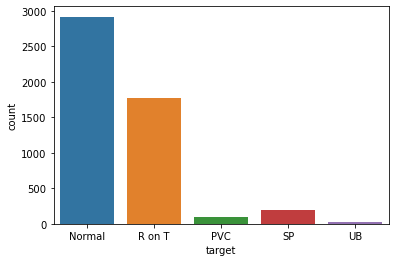

In [10]:
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
%matplotlib inline

ax = sns.countplot(df.target)
# rename xlabels as class names
ax.set_xticklabels(class_names);

Let's plot an averaged line chart of ECG for different classes to gain an intuitive understanding.

In [11]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

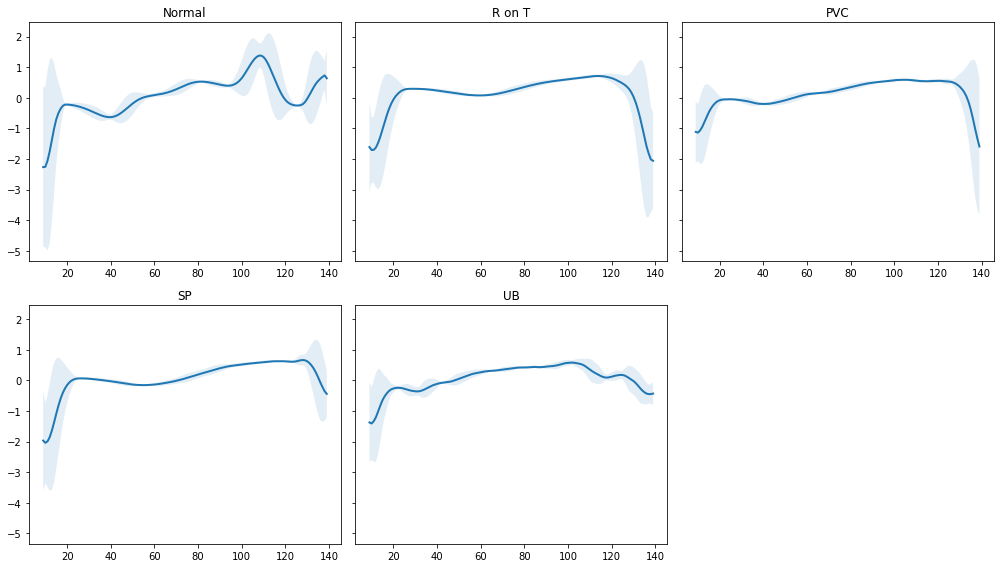

In [12]:
import matplotlib.pyplot as plt
classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

The figure above shows that normal class has a distinctly different shape compared to others.

## Step 3: Data Pre-processing

In [13]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [14]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We need to split the dataset to train, validation and test for model validation and testing purpose.

In [15]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

train_df, val_df = train_test_split(
    normal_df,
    test_size=0.15,
    random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
    val_df,
    test_size=0.33,
    random_state=RANDOM_SEED
)

In [16]:
def create_tensor(df):
    """
        This will convert ECG time series data into a 2D tensor where shape = (sequence length * number of features)
    """
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [17]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [18]:
print(type(train_df))
sequences = train_df.astype(np.float32).to_numpy().tolist()
print(type(sequences))
print(len(sequences[0]))
dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
print(dataset[0].shape)
n_seq, seq_len, n_features = torch.stack(dataset).shape
print(n_seq, seq_len, n_features)

<class 'pandas.core.frame.DataFrame'>
<class 'list'>
140
torch.Size([140, 1])
2481 140 1


But first let us import some necessary pytorch packages.

Time to use our helper function.

In [19]:
train_dataset, seq_len, n_features = create_tensor(train_df)
val_dataset, _, _ = create_tensor(val_df)
test_normal_dataset, _, _ = create_tensor(test_df)
test_anomaly_dataset, _, _ = create_tensor(anomaly_df)

In [20]:
# let's inspect the created tensors
len(train_dataset[0])

140

After completing data preparation, we can now start to define our model architecture prior to training.

In [21]:
# this is the architecture for encoder

class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [22]:
# this is architecture for decoder

class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

Ok, after defining both architecture for encoder and decoder, let's wrap them into a module for ease of calling

In [23]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

Let's create an instance of autoencoder using our newly-created function

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


We will also write a helper function for the training process.

In [25]:
import copy

def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

"At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:
"

In [26]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=5
)

Epoch 1: train loss 60.989060467647384 val loss 56.22508238444149
Epoch 2: train loss 53.979363060535704 val loss 51.4514624690033


KeyboardInterrupt: 

Let's plot the model loss by epochs to gain an understanding of the model performance.

NameError: name 'history' is not defined

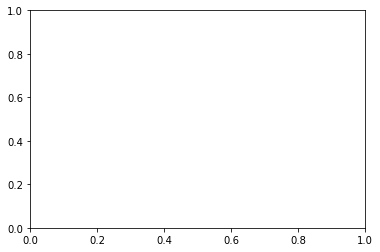

In [27]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Source:
1. https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa#scrollTo=NA0k8mTijyh-
2. https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/
3. https://blogs.oracle.com/datascience/introduction-to-anomaly-detection (for statistical technique)
4. http://timeseriesclassification.com/description.php?Dataset=ECG5000 (dataset)